# Improving  Accuracy 

    The idea with this investigation is to first see if 
    
* I did mess up and not use all the data from split 1. 
    
* Also experiment with using all splits for training (actually not sure that legal, I think the splits are essentially k fold splits). k fold splits helps reduce bias (but increases variance). k = 3 is usually recommended. 
    
* Fine tuning 2nd to last layer 

* Add new accuracy metric 
* play around with drop out 
    

# Data accuracy mess up

Need to check that I'm not simply getting the first frame in all examples


In [1]:
import os
import sys


up1 = os.path.abspath('../utils/') 
up2 = os.path.abspath('../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
# Parameters
params = { 'data_dir' : "/data",
          'dim': (224,224),
          'batch_size': 32,
          'n_classes': 101,
          'n_channels': 3,
          'shuffle': True,
        'validation' : False}

In [3]:
from spatial_data_gen import DataGenerator
from ucf101_data_utils import get_test_data, get_train_data
from spatial_network import getVggModel, getResNet50Model, getVggModel2
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [4]:
len([name for name in os.listdir('/data/jpegs_256/v_JavelinThrow_g05_c01/') if os.path.isfile(name)])

0

Essentially I did above to count the number of frames, unfortunately, if files expects absolute path, so above does not work and fails very badly!

In [7]:
id_labels_train = get_train_data('../data/ucf101_splits/trainlist01.txt')
id_labels_test = get_test_data('../data/ucf101_splits/testlist01.txt',
                              '../data/ucf101_splits/classInd.txt')

training_generator = DataGenerator(*id_labels_train, **params)
params['validation'] = True
validation_generator = DataGenerator(*id_labels_test, **params)

In [6]:
X = None
y = None

for (_x, _y) in training_generator:
    X = _x
    y = _y
    break
X.shape

(32, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


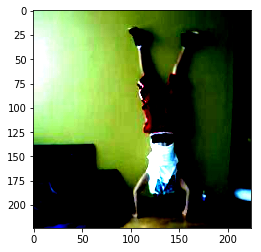

In [7]:
draw = cv2.cvtColor(X[19,], cv2.COLOR_BGR2RGB)
plt.imshow(draw)

In [8]:

model=getVggModel((224,224,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:


mypotim = SGD(lr=1e-4, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [10]:
mod1 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=1,
                    verbose=1)

Epoch 1/1
298/298 [==============================] - 179s 601ms/step - loss: 4.4970 - acc: 0.0465 - val_loss: 4.3937 - val_acc: 0.0726


In [11]:
mod1 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 122s 409ms/step - loss: 4.0807 - acc: 0.1539 - val_loss: 4.0710 - val_acc: 0.1467
Epoch 2/20
298/298 [==============================] - 121s 406ms/step - loss: 3.6085 - acc: 0.2962 - val_loss: 3.7069 - val_acc: 0.2270
Epoch 3/20
298/298 [==============================] - 121s 407ms/step - loss: 3.1449 - acc: 0.4074 - val_loss: 3.3826 - val_acc: 0.2916
Epoch 4/20
298/298 [==============================] - 121s 406ms/step - loss: 2.7371 - acc: 0.5039 - val_loss: 3.1009 - val_acc: 0.3551
Epoch 5/20
298/298 [==============================] - 121s 405ms/step - loss: 2.3880 - acc: 0.5866 - val_loss: 2.8969 - val_acc: 0.3848
Epoch 6/20
298/298 [==============================] - 121s 405ms/step - loss: 2.1131 - acc: 0.6383 - val_loss: 2.7028 - val_acc: 0.4211
Epoch 7/20
298/298 [==============================] - 122s 408ms/step - loss: 1.8861 - acc: 0.6814 - val_loss: 2.5550 - val_acc: 0.4420
Epoch 8/20
298/298 [============================

In [12]:
model.save_weights(filepath='../data/weights/spatial_model_weights_epoch21.hdf5')

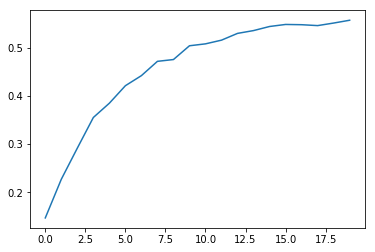

In [19]:
plt.plot(mod1.history['val_acc'])


In [20]:
mod2 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=10,
                    verbose=1)

Epoch 1/10
298/298 [==============================] - 121s 406ms/step - loss: 0.6940 - acc: 0.8861 - val_loss: 1.8259 - val_acc: 0.5530
Epoch 2/10
298/298 [==============================] - 121s 405ms/step - loss: 0.6581 - acc: 0.8940 - val_loss: 1.7922 - val_acc: 0.5551
Epoch 3/10
298/298 [==============================] - 122s 408ms/step - loss: 0.6359 - acc: 0.8969 - val_loss: 1.7766 - val_acc: 0.5617
Epoch 4/10
298/298 [==============================] - 121s 407ms/step - loss: 0.6105 - acc: 0.8986 - val_loss: 1.7248 - val_acc: 0.5699
Epoch 5/10
298/298 [==============================] - 122s 408ms/step - loss: 0.5904 - acc: 0.9048 - val_loss: 1.7376 - val_acc: 0.5697
Epoch 6/10
298/298 [==============================] - 121s 408ms/step - loss: 0.5698 - acc: 0.9060 - val_loss: 1.7296 - val_acc: 0.5662
Epoch 7/10
298/298 [==============================] - 121s 406ms/step - loss: 0.5443 - acc: 0.9112 - val_loss: 1.6915 - val_acc: 0.5797
Epoch 8/10
298/298 [============================

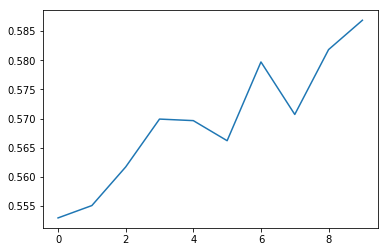

In [21]:
plt.plot(mod2.history['val_acc'])

In [22]:
model.save_weights(filepath='../data/weights/spatial_model_weights_epoch31.hdf5')

In [23]:
model2=getVggModel((224,224,3), printmod=0)
model2.load_weights('../data/weights/spatial_model_weights_epoch31.hdf5')

In [24]:

for i, layer in enumerate(model2.layers): 
    if 'block5' in layer.name:
        layer.trainable = True

In [26]:
mypotim = SGD(lr=0.5e-4, momentum=0.9)
model2.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [27]:
mod3 = model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=5,
                    verbose=1)

Epoch 1/5
298/298 [==============================] - 133s 446ms/step - loss: 0.3459 - acc: 0.9289 - val_loss: 1.5952 - val_acc: 0.5877
Epoch 2/5
298/298 [==============================] - 132s 443ms/step - loss: 0.2707 - acc: 0.9323 - val_loss: 1.6317 - val_acc: 0.5927
Epoch 3/5
298/298 [==============================] - 132s 444ms/step - loss: 0.2422 - acc: 0.9390 - val_loss: 1.6379 - val_acc: 0.5943
Epoch 4/5
298/298 [==============================] - 132s 442ms/step - loss: 0.2238 - acc: 0.9443 - val_loss: 1.6333 - val_acc: 0.5975
Epoch 5/5
298/298 [==============================] - 132s 442ms/step - loss: 0.2105 - acc: 0.9445 - val_loss: 1.6524 - val_acc: 0.5943


In [28]:
mod4 = model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=15,
                    verbose=1)

Epoch 1/15
298/298 [==============================] - 132s 444ms/step - loss: 0.1913 - acc: 0.9517 - val_loss: 1.6480 - val_acc: 0.5951
Epoch 2/15
298/298 [==============================] - 132s 443ms/step - loss: 0.1798 - acc: 0.9538 - val_loss: 1.6384 - val_acc: 0.6017
Epoch 3/15
298/298 [==============================] - 132s 443ms/step - loss: 0.1691 - acc: 0.9567 - val_loss: 1.6304 - val_acc: 0.6128
Epoch 4/15
298/298 [==============================] - 132s 443ms/step - loss: 0.1500 - acc: 0.9611 - val_loss: 1.6855 - val_acc: 0.6001
Epoch 5/15
298/298 [==============================] - 132s 444ms/step - loss: 0.1620 - acc: 0.9573 - val_loss: 1.6741 - val_acc: 0.6035
Epoch 6/15
298/298 [==============================] - 132s 442ms/step - loss: 0.1383 - acc: 0.9645 - val_loss: 1.6619 - val_acc: 0.6033
Epoch 7/15
298/298 [==============================] - 132s 443ms/step - loss: 0.1400 - acc: 0.9648 - val_loss: 1.6528 - val_acc: 0.6102
Epoch 8/15
298/298 [============================

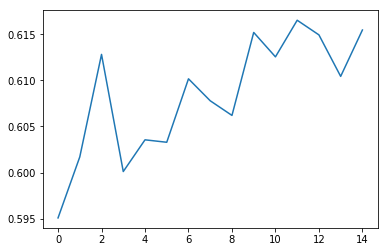

In [29]:
plt.plot(mod4.history['val_acc'])

In [30]:
model2.save_weights(filepath='../data/weights/spatial_model_weights_epoch51.hdf5')

## Results

So I only got 3 % improvement using the improved data source. What would be interesting is adding even more data augmentation and potentially also  using a more complicated fc layer.  

I think the fact that training accuracy is tending to 100%  means that my model has learned all that it can from the data. In a sense its not seeing features in certain data  sets  which would be useful for the validation set (Its overfitting). I definitely need to regularise more. 

# ResNet

In [10]:
model=getResNet50Model((224,224,3))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
mypotim = SGD(lr=1e-4, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [14]:
res_mod1 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=1,
                    verbose=1)

Epoch 1/1
298/298 [==============================] - 115s 385ms/step - loss: 1.4724 - acc: 0.5888 - val_loss: 6.3901 - val_acc: 0.0138


'm fairly convinced reset is overfitting my data quite a lot. I'm going to try the same fc layer and see what happens

In [4]:
model=getVggModel2((224,224,3), printmod=0)

In [5]:
mypotim = SGD(lr=1e-4, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [8]:
mod1 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=1,
                    verbose=1)

Epoch 1/1
298/298 [==============================] - 125s 421ms/step - loss: 4.6713 - acc: 0.0136 - val_loss: 4.5807 - val_acc: 0.0275


In [9]:
mod2 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=10,
                    verbose=1)

Epoch 1/10
298/298 [==============================] - 122s 410ms/step - loss: 4.5906 - acc: 0.0164 - val_loss: 4.5689 - val_acc: 0.0355
Epoch 2/10
298/298 [==============================] - 122s 409ms/step - loss: 4.5665 - acc: 0.0204 - val_loss: 4.5295 - val_acc: 0.0506
Epoch 3/10
298/298 [==============================] - 122s 410ms/step - loss: 4.5329 - acc: 0.0294 - val_loss: 4.4962 - val_acc: 0.0675
Epoch 4/10
298/298 [==============================] - 122s 409ms/step - loss: 4.4907 - acc: 0.0368 - val_loss: 4.4391 - val_acc: 0.0829
Epoch 5/10
298/298 [==============================] - 122s 411ms/step - loss: 4.4409 - acc: 0.0488 - val_loss: 4.3965 - val_acc: 0.1136
Epoch 6/10
298/298 [==============================] - 122s 409ms/step - loss: 4.3838 - acc: 0.0597 - val_loss: 4.3185 - val_acc: 0.1324
Epoch 7/10
298/298 [==============================] - 122s 409ms/step - loss: 4.3223 - acc: 0.0703 - val_loss: 4.2608 - val_acc: 0.1483
Epoch 8/10
298/298 [============================

In [10]:
mod2 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 123s 412ms/step - loss: 4.0160 - acc: 0.1215 - val_loss: 3.9262 - val_acc: 0.2360
Epoch 2/20
298/298 [==============================] - 122s 410ms/step - loss: 3.9321 - acc: 0.1408 - val_loss: 3.8497 - val_acc: 0.2593
Epoch 3/20
298/298 [==============================] - 122s 410ms/step - loss: 3.8499 - acc: 0.1571 - val_loss: 3.7577 - val_acc: 0.2717
Epoch 4/20
298/298 [==============================] - 122s 410ms/step - loss: 3.7581 - acc: 0.1703 - val_loss: 3.6554 - val_acc: 0.2987
Epoch 5/20
298/298 [==============================] - 122s 410ms/step - loss: 3.6832 - acc: 0.1757 - val_loss: 3.5759 - val_acc: 0.3030
Epoch 6/20
298/298 [==============================] - 122s 409ms/step - loss: 3.6026 - acc: 0.1935 - val_loss: 3.4847 - val_acc: 0.3125
Epoch 7/20
298/298 [==============================] - 122s 410ms/step - loss: 3.5159 - acc: 0.2085 - val_loss: 3.3803 - val_acc: 0.3350
Epoch 8/20
298/298 [============================

In [11]:
model.save_weights(filepath='../data/weights/spatial2_model_weights_epoch31.hdf5')

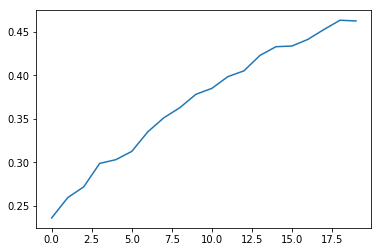

In [12]:
plt.plot(mod2.history['val_acc'])

In [13]:
mod3 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 123s 412ms/step - loss: 2.5225 - acc: 0.3959 - val_loss: 2.4633 - val_acc: 0.4735
Epoch 2/20
298/298 [==============================] - 123s 412ms/step - loss: 2.4576 - acc: 0.4006 - val_loss: 2.4349 - val_acc: 0.4849
Epoch 3/20
298/298 [==============================] - 123s 411ms/step - loss: 2.3906 - acc: 0.4187 - val_loss: 2.3581 - val_acc: 0.4926
Epoch 4/20
298/298 [==============================] - 123s 412ms/step - loss: 2.3424 - acc: 0.4297 - val_loss: 2.3311 - val_acc: 0.4921
Epoch 5/20
298/298 [==============================] - 122s 411ms/step - loss: 2.2876 - acc: 0.4462 - val_loss: 2.2758 - val_acc: 0.5005
Epoch 6/20
298/298 [==============================] - 123s 411ms/step - loss: 2.2514 - acc: 0.4487 - val_loss: 2.2243 - val_acc: 0.4950
Epoch 7/20
298/298 [==============================] - 123s 411ms/step - loss: 2.1896 - acc: 0.4633 - val_loss: 2.2225 - val_acc: 0.5061
Epoch 8/20
298/298 [============================

In [14]:
model.save_weights(filepath='../data/weights/spatial2_model_weights_epoch51.hdf5')

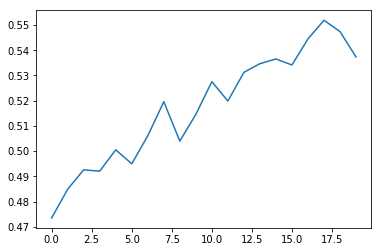

In [15]:
plt.plot(mod3.history['val_acc'])

In [16]:
model2=getVggModel2((224,224,3), printmod=0)
model2.load_weights('../data/weights/spatial2_model_weights_epoch51.hdf5')

In [18]:
for i, layer in enumerate(model2.layers): 
    if 'block5' in layer.name:
        layer.trainable = True

In [19]:
mypotim = SGD(lr=0.5e-4, momentum=0.9)
model2.compile(loss='categorical_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [20]:
mod4 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=10,
                    verbose=1)

Epoch 1/10
298/298 [==============================] - 122s 411ms/step - loss: 1.7111 - acc: 0.5668 - val_loss: 1.8913 - val_acc: 0.5548
Epoch 2/10
298/298 [==============================] - 123s 414ms/step - loss: 1.6611 - acc: 0.5840 - val_loss: 1.8721 - val_acc: 0.5556
Epoch 3/10
298/298 [==============================] - 123s 412ms/step - loss: 1.6109 - acc: 0.5876 - val_loss: 1.8580 - val_acc: 0.5551
Epoch 4/10
298/298 [==============================] - 122s 411ms/step - loss: 1.5925 - acc: 0.5925 - val_loss: 1.8300 - val_acc: 0.5596
Epoch 5/10
298/298 [==============================] - 122s 411ms/step - loss: 1.5502 - acc: 0.6066 - val_loss: 1.8289 - val_acc: 0.5577
Epoch 6/10
298/298 [==============================] - 123s 414ms/step - loss: 1.5233 - acc: 0.6106 - val_loss: 1.8035 - val_acc: 0.5649
Epoch 7/10
298/298 [==============================] - 123s 411ms/step - loss: 1.5142 - acc: 0.6159 - val_loss: 1.7894 - val_acc: 0.5641
Epoch 8/10
298/298 [============================

In [21]:
mod4 = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=4, epochs=20,
                    verbose=1)

Epoch 1/20
298/298 [==============================] - 123s 413ms/step - loss: 1.4182 - acc: 0.6400 - val_loss: 1.7430 - val_acc: 0.5739
Epoch 2/20
298/298 [==============================] - 123s 413ms/step - loss: 1.4007 - acc: 0.6384 - val_loss: 1.7194 - val_acc: 0.5810
Epoch 3/20
298/298 [==============================] - 122s 410ms/step - loss: 1.3685 - acc: 0.6463 - val_loss: 1.7121 - val_acc: 0.5718
Epoch 4/20
298/298 [==============================] - 123s 413ms/step - loss: 1.3516 - acc: 0.6602 - val_loss: 1.6954 - val_acc: 0.5771
Epoch 5/20
298/298 [==============================] - 122s 410ms/step - loss: 1.3115 - acc: 0.6643 - val_loss: 1.6976 - val_acc: 0.5736
Epoch 6/20
298/298 [==============================] - 123s 413ms/step - loss: 1.3136 - acc: 0.6642 - val_loss: 1.6829 - val_acc: 0.5890
Epoch 7/20
298/298 [==============================] - 122s 411ms/step - loss: 1.3091 - acc: 0.6673 - val_loss: 1.6713 - val_acc: 0.5757
Epoch 8/20
298/298 [============================

In [22]:
model.save_weights(filepath='../data/weights/spatial2_model_weights_epoch81.hdf5')